In [1]:
import bench_lib
import numpy as np
import matplotlib.pyplot as plt
import bench_plot_lib as plot_lib

In [2]:
GiB = 2**30

SYS_NAME = "cache_ext"
iops_select_fn = lambda r: r["jobs"][0]["read"]["iops"]


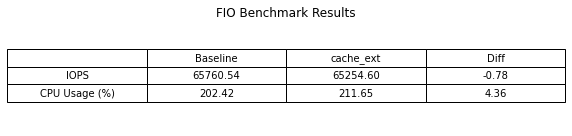

In [19]:
# Plot fio results

fio_results = bench_lib.parse_results_file("results.json", bench_lib.BenchResults)

cgroup_size = 20 * GiB

baseline_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "baseline_test",
    "cgroup_size": cgroup_size,
}

cache_ext_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "cache_ext_test",
    "cgroup_size": cgroup_size,
}

baseline_iops = plot_lib.results_select(fio_results, baseline_config_match, iops_select_fn)
baseline_iops = np.mean(baseline_iops)
cache_ext_iops = plot_lib.results_select(fio_results, cache_ext_config_match, iops_select_fn)
cache_ext_iops = np.mean(cache_ext_iops)
iops_diff = (cache_ext_iops - baseline_iops) / cache_ext_iops * 100

baseline_cpu_usage = plot_lib.results_select(fio_results, baseline_config_match, lambda r: r["cpu_usage"])
baseline_cpu_usage = np.mean(baseline_cpu_usage) / baseline_iops * 1000000
cache_ext_cpu_usage = plot_lib.results_select(fio_results, cache_ext_config_match, lambda r: r["cpu_usage"])
cache_ext_cpu_usage = np.mean(cache_ext_cpu_usage) / cache_ext_iops * 1000000
cpu_usage_diff = (cache_ext_cpu_usage - baseline_cpu_usage) / cache_ext_cpu_usage * 100

# print(baseline_cpu_usage)

# Put in a table
# Create a table with matplotlib
fig, ax = plt.subplots(figsize=(8, 2))  # Adjust figure size as needed
ax.axis("off")  # Hide axes

table_data = [
    ["IOPS", f"{baseline_iops:.2f}", f"{cache_ext_iops:.2f}", f"{iops_diff:.2f}"],
    ["CPU Usage (%)", f"{baseline_cpu_usage:.2f}", f"{cache_ext_cpu_usage:.2f}", f"{cpu_usage_diff:.2f}"],
]

table = ax.table(cellText=table_data,
                 colLabels=["", "Baseline", SYS_NAME, "Diff"],
                 cellLoc="center",
                 loc="center")

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # Adjust table size

plt.title("FIO Benchmark Results")
plt.tight_layout()
plt.show()


In [4]:
plot_lib.config_combinations(fio_results, ["cgroup_name", "cgroup_size"])

[{'cgroup_name': 'baseline_test', 'cgroup_size': 5368709120},
 {'cgroup_name': 'cache_ext_test', 'cgroup_size': 5368709120},
 {'cgroup_name': 'baseline_test', 'cgroup_size': 10737418240},
 {'cgroup_name': 'cache_ext_test', 'cgroup_size': 10737418240},
 {'cgroup_name': 'baseline_test', 'cgroup_size': 21474836480},
 {'cgroup_name': 'cache_ext_test', 'cgroup_size': 21474836480}]